In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import scipy.integrate as integ
from scipy.optimize import curve_fit
import time
import json
import os

In [49]:
def read_waveforms_from_json( PE = 1, angle = 0, plot = False ):
    wfs = []
    path = '/home/dandrea/abalone_simulation/results/SiPM'
    t_start = time.time()
    #os.listdir(directory)
    i = 1
    filename = f'{path}/SiPM_readout_{PE}_{angle}_run_{i}.txt'
    while os.path.isfile(filename):
        with open(filename) as f:
            for jsonObj in f:
                wfDict = json.loads(jsonObj)
                try: wfs.append(wfDict['voltages'])
                except: pass
        filename = f'{path}/SiPM_readout_{PE}_{angle}_run_{i}.txt'
        i += 1
    nwf = len(wfs)
    print(f'Number of waveforms {nwf}, time to read {time.time() - t_start:.2f}')
    if plot:
        plt.figure(figsize=(8,4.5))
        for i in range(10):
            plt.plot(wfs[i],label=f'waveform {i}')
        plt.xlabel('time (ns)', ha='right', x=1)
        plt.ylabel('voltages (a.u.)', ha='right', y=1)
        #plt.ylim(0,2)
        #plt.legend()
        plt.savefig('waveforms.png',dpi=600)
    return np.array(wfs)

Number of waveforms 10005, time to read 7.99


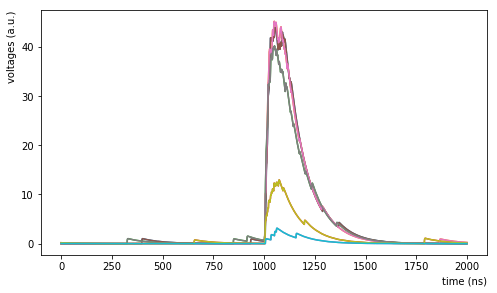

In [50]:
wfs = read_waveforms_from_json(plot = True)

In [14]:
def search_peaks(wf, n, ampllim = 9, simulation = False, plot = False): # search all the peaks of the signal
    # n: nb of bin-size for the dled delay (dled = "discret derivative")
    # ampllim: min amplitude to select a peak
    L = []
    t = np.arange(0,len(wf))
    # derivative
    if simulation: dled = wf[n:] - wf[:-n]
    else: dled = wf[:-n] - wf[n:]
    if plot:
        plt.figure(figsize=(8,4.5))
        plt.plot(t[:-n], dled, label = 'dled signal')
        plt.xlabel(r'samples',ha='right',x=1)
        plt.ylabel('amplitude',ha='right',y=1)
        plt.legend()
    N = np.array([i for i in range(len(dled))]) # we will work in term of bin-size instead of time
    N1 = N[dled >= ampllim]
    while len(N1) != 0:
        n1 = N1[0]
        N, dled = N[N >= n1], dled[N >= n1]
        N2 = N[dled < ampllim]
        if len(N2) != 0:
            n2 = N2[0]
        else:
            n2 = N[-1]
        L.append(n1)
        L.append(n2)
        N, dled = N[N > n2], dled[N > n2]
        N1 = N[dled >= ampllim]
        if plot: plt.plot( (n1+n2)/2, 0, "x")
    #L.append(len(wf)-1)
    return L

In [37]:
def expo_neg(c):
    return(lambda x, a, b : c - a*np.exp(-b*x))
def expo_pos(c):
    return(lambda x, a, b : c + a*np.exp(-b*x))
def integral_simulation_peaks( wf, peaks_list, dtl = -2, dtr = 1,
                  tfit = 20, tlim = 100, tc = 5, tll = 5, tlr = 10, central=True, plot=False):
    # tlim = time window of the fit integration
    # tfit = time window of the fit
    # tc = min time to consider 2 peaks independently
    # tll = left limit of the window to search baseline value
    # tlr = right limit of the window to search Amax
    inttot = 0
    tt = np.array([i for i in range(len(wf))]) # time in bin-size
    tplot_tot = []
    A_tot = []
    integrals = []
    for i in range(len(peaks_list)//2):
        dt = peaks_list[2*i + 1] - peaks_list[2*i]
        if dt < tc: continue #skip peaks if is too close to next one
        tlo = peaks_list[2*i]-tll
        if tlo < 0: tlo = 0
        bl = np.max(wf[tlo:peaks_list[2*i]+1])
        Am = wf[peaks_list[2*i]:peaks_list[2*i+1] + tlr]
        ttm = tt[peaks_list[2*i]:peaks_list[2*i+1] + tlr]
        amp = np.max(Am) #local amplitude of the signal
        tmin = ttm[Am == amp][0]
        tl = tt[(tt <= tmin+dtr) & (tt >= tmin+dtl)]
        wfl = wf[(tt <= tmin+dtr) & (tt >= tmin+dtl)]
        Il = integ.simps(wfl, tl/100)
        
        # calculation of real integral of the waveform
        real_t = tt[(tt <= tmin+tlim) & (tt >= tmin+dtl)]
        real_wf = wf[(tt <= tmin+tlim) & (tt >= tmin+dtl)]
        intreal = integ.simps(real_wf, real_t/100)
        tr = tt[tmin+dtr:tmin+tfit] # time window for the fit
        if central: mask = (len(tr) >= 5 and amp > 5 and np.abs(tmin-len(wf)/2) < 50)
        else: mask = (len(tr) >= 5 and amp < 5 and np.abs(tmin-len(wf)/2) < 900)
        if mask:
            tr2 = tr - tr[0]
            #print('tmin:',tmin,'bl:',bl,'amp max:',amp)
            #try:
            fct_fit = expo_pos(bl) # fct used for the fit
            popt, pcov = curve_fit(fct_fit, tr2/100, wf[tr],
                                    p0 = np.array([amp, 6.8]),
                                    bounds =  ([amp/1.5, 1], [amp*1.5, 10]))
            a, b = popt
            tnew = tt[tr[0]:]
            if plot:
                plt.figure(figsize=(8,4.5))
                fct_fit_tot = fct_fit((tnew-tr[0])/100,a,b)
                tnew2 = min(tlim, tt[-1]-tr[0])
                tplot = tt[tmin+dtl-20:tmin+tnew2+20]
                plt.plot(tplot/100,wf[tmin+dtl-20:tmin+tnew2+20],label='SiPM signal')
                plt.plot(tnew[:tnew2]/100, fct_fit_tot[:tnew2],
                         label=f'fit f(x) = baseline - a*exp(-b*x):\n a = {a:.2f}, b = {b:.2f}')
                plt.axhline(bl, color = 'r', label = 'baseline')
                plt.vlines((tmin+dtl)/100, wf[tmin+dtl]-10, bl+10, colors = 'g',
                           label = 'integration limits')
                plt.vlines((tmin+dtr)/100, wf[tmin+dtr]-10, bl+10, colors = 'g')
                plt.vlines((tmin+tfit)/100, wf[tmin+tfit]-10, bl+10, colors = 'c',
                           label = 'fit limit')
                plt.vlines((tmin+tlim)/100, wf[tmin+tlim]-10, bl+10, colors = 'g')
                plt.xlabel(r'time ($\mu s$)',ha='right',x=1)
                plt.ylabel('amplitude',ha='right',y=1)
                plt.legend()
                tlimplot = tr[0]
            fct_int = lambda x : bl + fct_fit(x, a, b)
            #print('bl, a, b : ', bl, a, b)
            Ir, err = integ.quad(fct_int, 0, (tlim-dtr)/100)
            inttot = Il + Ir
            integrals.append(inttot)
            #print(f'Amp: {amp:.2f} Integral: {Il:.3f} + {Ir:.3f} = {inttot:.3f}')
            tl = tt[tt >= peaks_list[2*i+1]+dtl]
    return integrals

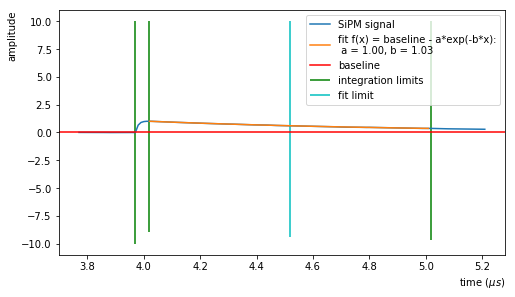

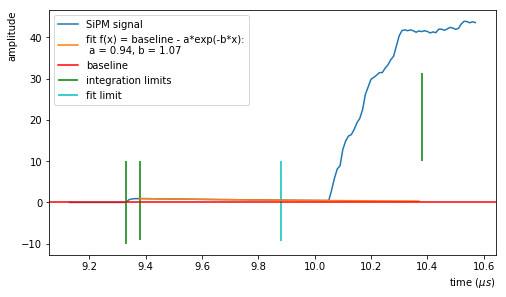

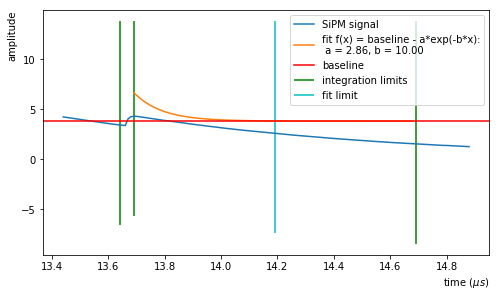

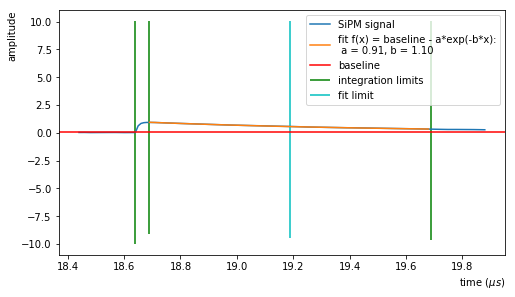

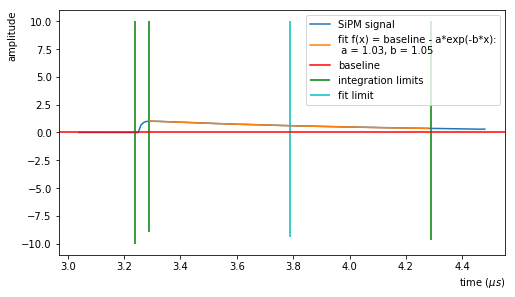

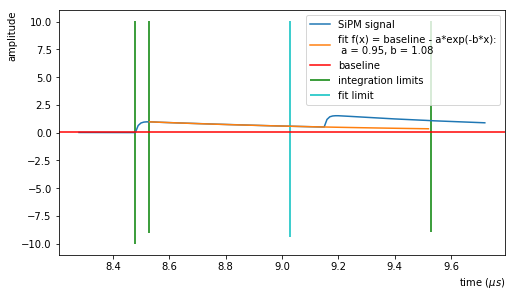

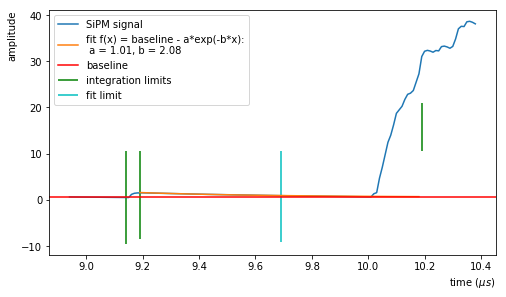

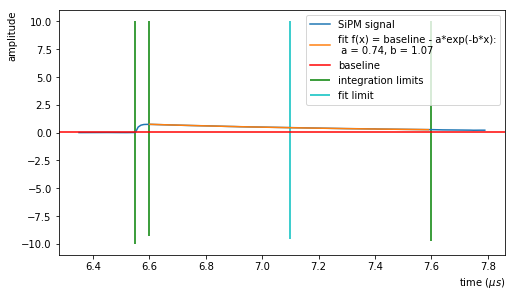

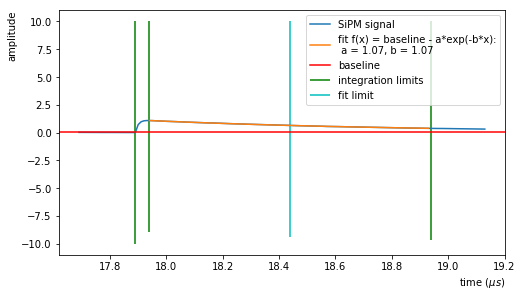

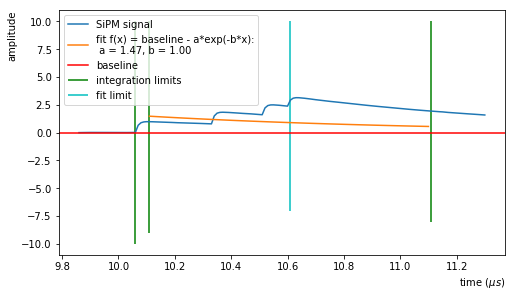

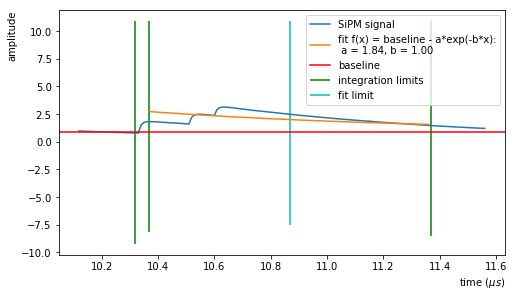

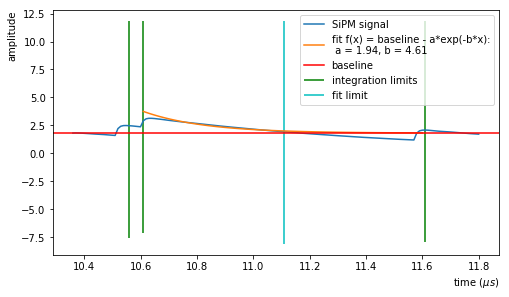

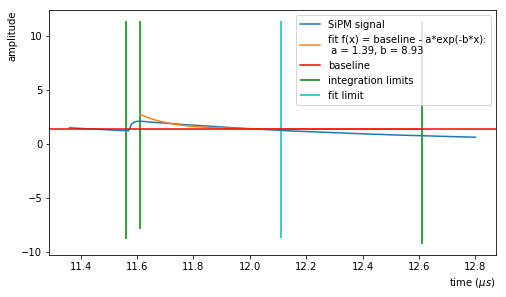

In [24]:
for i in range(5):
    listpeaks = search_peaks(wfs[i],5,0.5,simulation=True,plot=False)
    ints = integral_simulation_peaks(wfs[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

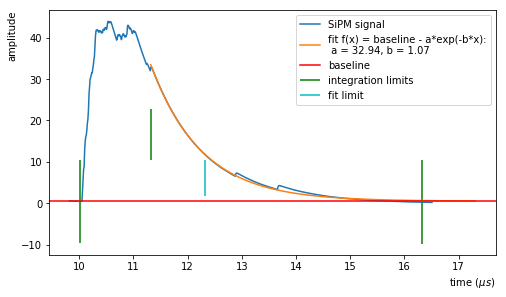

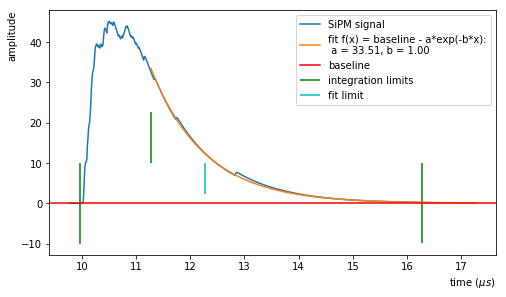

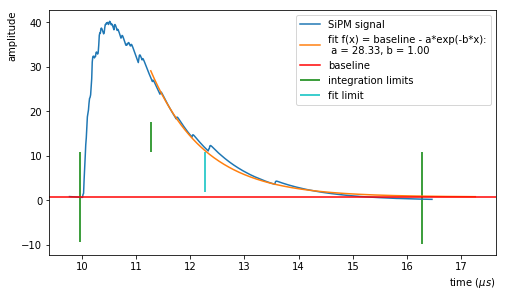

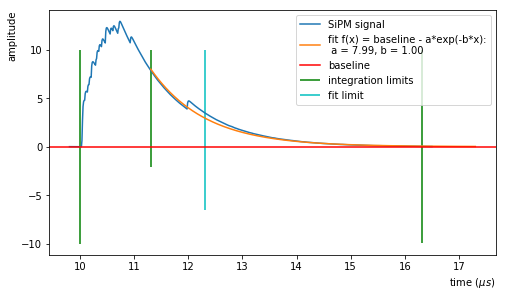

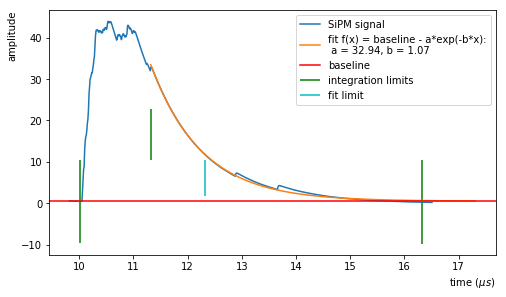

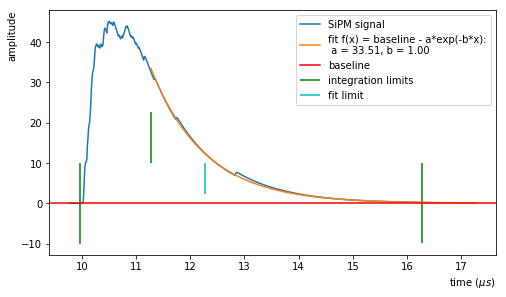

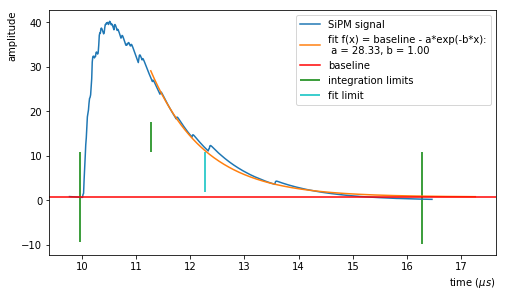

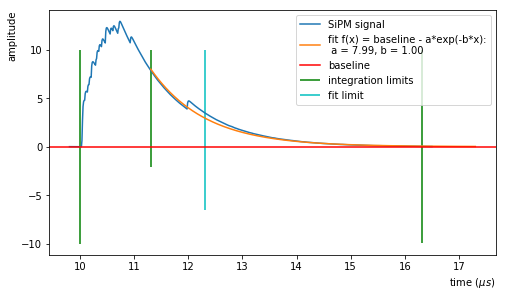

In [38]:
for i in range(10):
    listpeaks = search_peaks(wfs[i],5,0.5,simulation=True,plot=False)
    ints = integral_simulation_peaks(wfs[i],listpeaks,-30,100,200,600,15,8,10,plot=1)

In [51]:
integrals = []
t_start = time.time()
for i in range(len(wfs)):
    listpeaks = search_peaks(wfs[i],5,0.5,simulation=True,plot=False)
    ints = integral_simulation_peaks(wfs[i],listpeaks,-5,0,50,100,5,8,10,plot=0,central=0)
    integrals.append(ints)
    ints = integral_simulation_peaks(wfs[i],listpeaks,-30,100,200,600,15,8,10,plot=0,central=1)
    integrals.append(ints)
    diff = time.time() - t_start
    if (i % 500) == 0:
        print(f'event n. {i} time to process: {diff:.2f}')
integrals = np.concatenate(integrals)

event n. 0 time to process: 0.04
event n. 500 time to process: 15.42
event n. 1000 time to process: 30.10
event n. 1500 time to process: 44.93
event n. 2000 time to process: 60.34
event n. 2500 time to process: 75.36
event n. 3000 time to process: 90.28
event n. 3500 time to process: 104.94
event n. 4000 time to process: 120.03
event n. 4500 time to process: 134.55
event n. 5000 time to process: 149.82
event n. 5500 time to process: 164.44
event n. 6000 time to process: 179.08
event n. 6500 time to process: 193.58
event n. 7000 time to process: 208.59
event n. 7500 time to process: 223.22
event n. 8000 time to process: 237.78
event n. 8500 time to process: 252.33
event n. 9000 time to process: 267.21
event n. 9500 time to process: 282.39
event n. 10000 time to process: 296.60


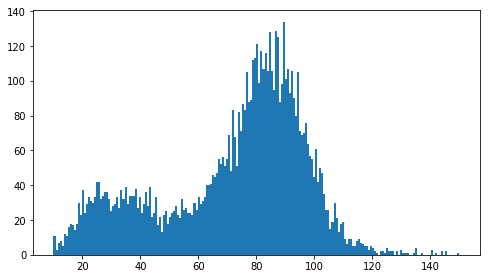

In [56]:
plt.figure(figsize=(8,4.5))
a = plt.hist(integrals,bins=200,range=(10,150))
#plt.yscale('log')